In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 讀取資料
df = pd.read_excel('20241208171255DataExport.xlsx')

<ipython-input-22-558ee8c5a0ab>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['年月'] = pd.to_datetime(df['年月'])


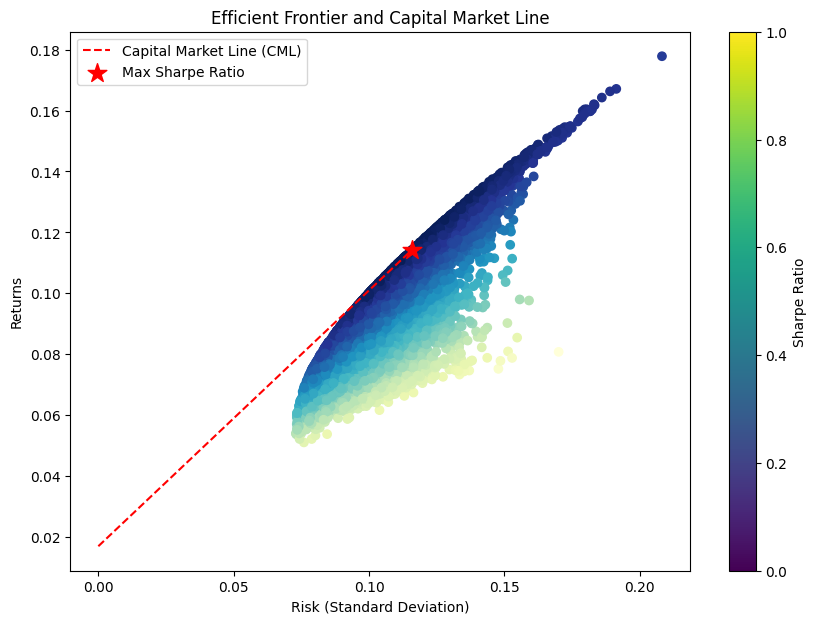

夏普比率最高的投資組合權重:
2330: 0.4311
2412: 0.3822
8926: 0.0692
9908: 0.1175


In [ ]:
# 確保資料按照日期排序並計算報酬率
df['年月'] = pd.to_datetime(df['年月'])
df = df.sort_values(by=['代號', '年月'])
df['報酬率'] = df.groupby('代號')['收盤價(元)'].pct_change()

# 將不同股票的報酬率轉換為數據透視表
returns_pivot = df.pivot(index='年月', columns='代號', values='報酬率').dropna()

# 計算資產的年化平均回報率和協方差矩陣
mean_returns = returns_pivot.mean() * 12  # 月度數據，年化回報
cov_matrix = returns_pivot.cov() * 12     # 月度數據，協方差矩陣年化

# 設定無風險資產的回報率
risk_free_rate = 0.017

# 投資組合模擬參數
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

np.random.seed(42)

# 模擬投資組合
for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    weights_record.append(weights)

    # 計算投資組合回報、風險和夏普比率
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev

    # 保存結果：回報、風險、夏普比率
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = sharpe_ratio

# 將模擬結果保存為DataFrame
results_frame = pd.DataFrame(results.T, columns=['Returns', 'Risk', 'Sharpe Ratio'])

# 找出夏普比率最高的投資組合
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_risk = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# 找到 CML 的斜率
cml_slope = (max_sharpe_return - risk_free_rate) / max_sharpe_risk

# 計算 x 軸 (風險) 的範圍，用於畫 CML
x_cml = np.linspace(0, max_sharpe_risk, 100)
y_cml = risk_free_rate + cml_slope * x_cml

# 繪製效率前緣和 CML
plt.figure(figsize=(10,7))
plt.scatter(results_frame['Risk'], results_frame['Returns'], c=results_frame['Sharpe Ratio'], cmap='YlGnBu', marker='o')
plt.plot(x_cml, y_cml, color='r', linestyle='--', label='Capital Market Line (CML)')
plt.scatter(max_sharpe_risk, max_sharpe_return, color='r', marker='*', s=200, label='Max Sharpe Ratio')
plt.title('Efficient Frontier and Capital Market Line')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')
plt.legend(loc='best')
plt.show()

# 列出夏普比率最高的投資組合的權重
print("夏普比率最高的投資組合權重:")
for i, (asset, weight) in enumerate(zip(returns_pivot.columns, max_sharpe_weights)):
    print(f'{asset}: {weight:.4f}')


In [ ]:
print(f"夏普比率最高的投資組合年化平均回報率: {max_sharpe_return:.4f}")

夏普比率最高的投資組合年化平均回報率: 0.1143


In [ ]:
max_sharpe_ratio = results[2, max_sharpe_idx]
print(f"夏普比率最高的投資組合的夏普比率: {max_sharpe_ratio:.4f}")

夏普比率最高的投資組合的夏普比率: 0.8398


In [ ]:
df1 = pd.read_excel('20241109165617DataExport.xlsx')
# 確保年月欄位為日期格式
df1['年月'] = pd.to_datetime(df1['年月'], errors='coerce')

# 刪除無法轉換為日期的行
df1 = df1.dropna(subset=['年月'])

# 按年月排序
df1 = df1.sort_values(by='年月')

# 計算每月的報酬率 (收盤價相對於前月收盤價的變動)
df1['月報酬率'] = df1['收盤價(元)'].pct_change()

# 移除空值（第一行無法計算月報酬率，會是NaN）
monthly_returns = df1['月報酬率'].dropna()

# 計算年化平均回報率
annualized_return = (1 + monthly_returns.mean()) ** 12 - 1

print(f"大盤的年化平均報酬率: {annualized_return:.4%}")

大盤的年化平均報酬率: 7.7596%


<Figure size 1200x600 with 0 Axes>

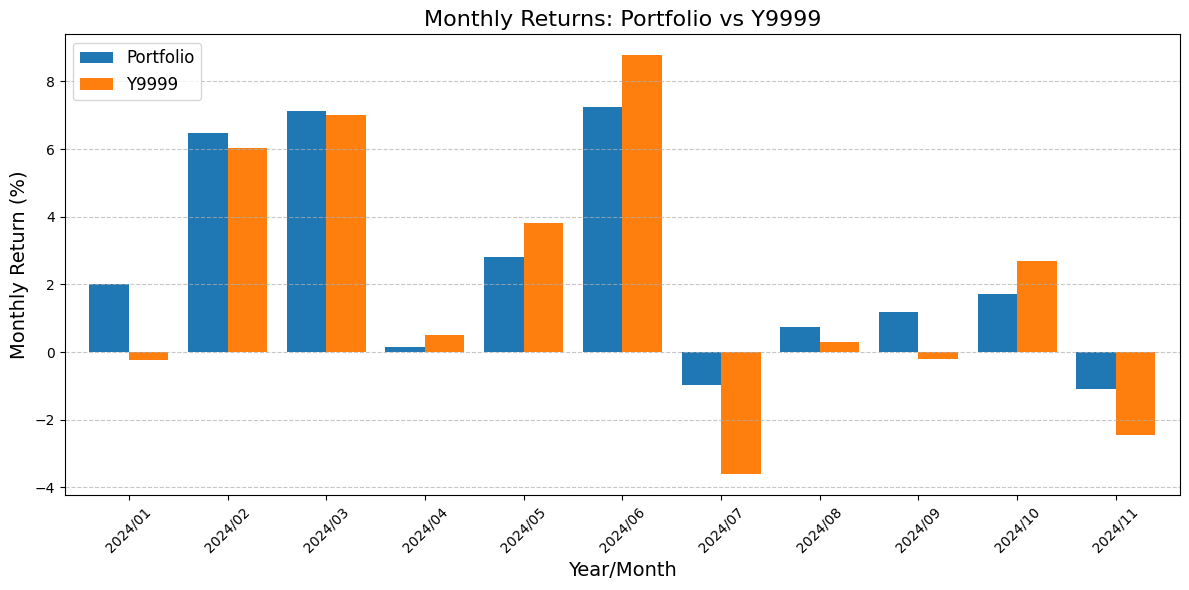

Portfolio Win Rate: 63.64%
Portfolio Average Monthly Return: 2.49%
Y9999 Average Monthly Return: 2.06%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取 Excel 檔案
data = pd.read_excel('樣本外測試.xlsx')

# 假設資料有以下結構
# 股票資料（投資組合）
portfolio_returns = data[data['代號'] != 'Y9999'].pivot(index='年月', columns='代號', values='報酬率％_月')

# 加權指數資料
index_returns = data[data['代號'] == 'Y9999'].set_index('年月')['報酬率％_月']

# 加權平均計算投資組合月報酬率
weights = {"2330": 0.4311, "2412": 0.3822, "8926": 0.0692, "9908": 0.1175}
portfolio_returns['Portfolio'] = portfolio_returns.mul(pd.Series(weights), axis=1).sum(axis=1)

# 將投資組合與加權指數合併為 DataFrame
comparison = pd.DataFrame({
    'Portfolio': portfolio_returns['Portfolio'],
    'Y9999': index_returns
})

# 繪製圖表
plt.figure(figsize=(12, 6))
comparison.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e'], width=0.8)
plt.title('Monthly Returns: Portfolio vs Y9999', fontsize=16)
plt.ylabel('Monthly Return (%)', fontsize=14)
plt.xlabel('Year/Month', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# 顯示圖表
plt.show()

# 勝率計算
win_rate = (comparison['Portfolio'] > comparison['Y9999']).mean()
print(f"Portfolio Win Rate: {win_rate:.2%}")

# 月平均報酬率計算
portfolio_avg = comparison['Portfolio'].mean()
index_avg = comparison['Y9999'].mean()

print(f"Portfolio Average Monthly Return: {portfolio_avg:.2f}%")
print(f"Y9999 Average Monthly Return: {index_avg:.2f}%")